## Energy Market in Tanzania: Market Entry Considerations

In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('agg')

In [2]:
# Set some constants
# https://data.worldbank.org/country/TZ
total_population = 65497748
# 2021 Exchange rate (USD): 0.0004
# https://www.exchangerates.org.uk/TZS-USD-spot-exchange-rates-history-2021.html
fx = 0.0004

In [3]:
# The first step is to fetch all the data
# determine the relative path of the folder holding the csv files
folder_path = "./TZA_2020_NPS-R5_v02_M_CSV"

In [4]:
# Initialize an empty dictionary to store the data (household and consumption data specifically)
data_dict = {}

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("hh_") or filename.startswith("consumption_"):
        # Create the variable name (removing the .csv extension)
        var_name = os.path.splitext(filename)[0]
        
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        data_dict[var_name] = pd.read_csv(file_path)

In [5]:
# List of all datasets:
data_dict.keys()

In [6]:
# Load the GeoJSON file
# Important for analysing geo data
# Downloaded from: https://energydata.info/dataset/tanzania-region-district-boundary-2012
gdf = gpd.read_file('regions.geojson')
gdf.head()

From the review of the data, it seems like the important datasets are:
1. hh_sec_a {y5_hhid}
2. hh_sec_b {y5_hhid, indidy5}
3. hh_sec_e2 (occupation data) {y5_hhid, indidy5}
3. hh_sec_e3 (firewood collection shows source of energy) {y5_hhid, indidy5}
4. hh_seg_g (financial status) {y5_hhid, indidy5}
5. hh_sec_j1 (food consumed) {y5_hhid, itemcode
6. hh_sec_m (household assets) {y5_hhid, itemcode}

### Columns of interest

In [ ]:
a_hh_basic = data_dict['hh_sec_a'][['y5_hhid','y5_rural','hh_a02_1',]].rename(columns = {'hh_a02_1':'location'})

# getting region and district info from the location column "hh_a02_1"
a_hh_basic['location'] = a_hh_basic['location'].astype(str)

# extract all but the last xter
a_hh_basic['region'] = a_hh_basic['location'].str[:-1]
# extract the last xter
a_hh_basic['district'] = a_hh_basic['location'].str[-1]

# convert region/district back into integers
a_hh_basic['region'] = a_hh_basic['region'].astype(int)
a_hh_basic['district'] = a_hh_basic['district'].astype(int)
a_hh_basic = a_hh_basic.drop(columns = ['location'])

# [OBS] region data does not align perfectly with "MAGERESHO YA MIKOA NA WILAYA" section
# of the questionairre
a_hh_basic.groupby(['region', 'district']).size().reset_index(name='count')

In [9]:
# Consumption data:
# Construction from nps_wave_5_report.pdf, appendix A.
# consumption is for 28 days
# data dictionaty: https://microdata.worldbank.org/index.php/catalog/5639/data-dictionary/F65?file_name=consumption_real_y5
data_dict['consumption_real_y5']#.columns

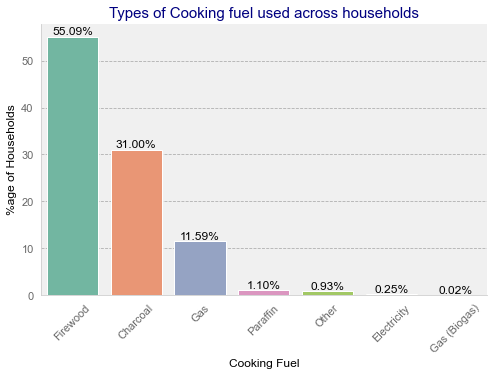

<Figure size 432x288 with 0 Axes>

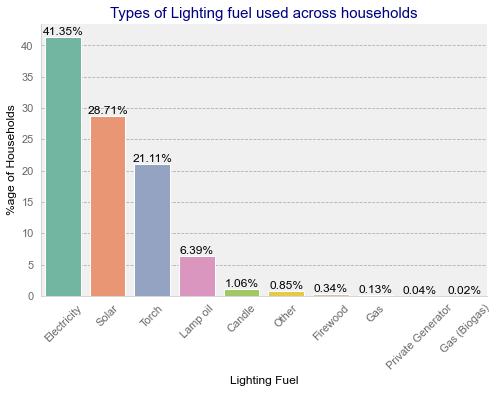

<Figure size 432x288 with 0 Axes>

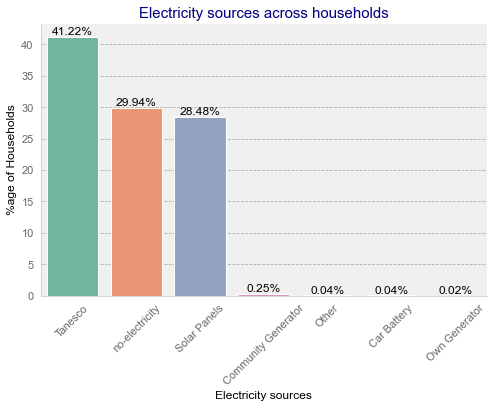

<Figure size 432x288 with 0 Axes>

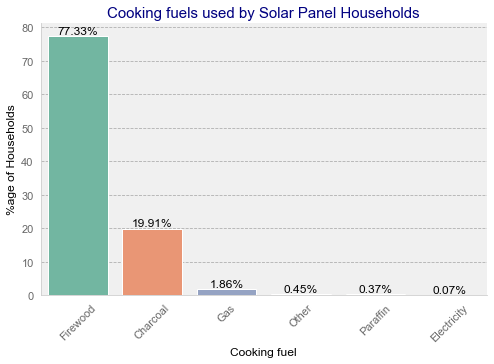

<Figure size 432x288 with 0 Axes>

#### Energy Data

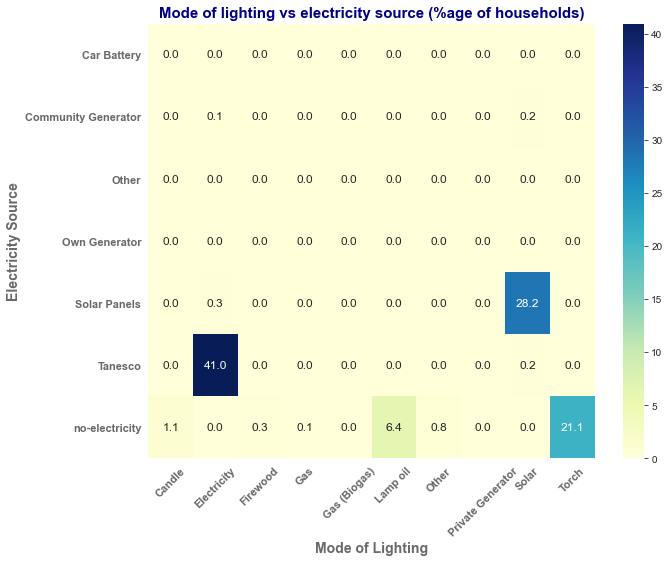

<Figure size 432x288 with 0 Axes>

In [20]:
i_hh_energy = data_dict['hh_sec_i'][['y5_hhid','hh_i16','hh_i16_1','hh_i17','hh_i18']].rename(columns = {
    'hh_i16':'cooking_fuel',
    'hh_i16_1':'cooking_stove',
    'hh_i17':'lighting_fuel',
    'hh_i18':'electricity_source'
})

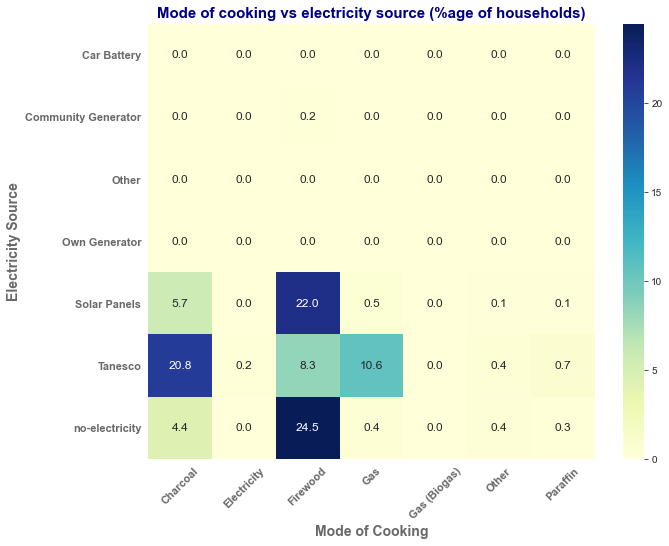

<Figure size 432x288 with 0 Axes>

In [21]:
# Create dictionaries to help in renaming the values in the columns
# Fuel used for cooking
ckfuel_dict = { 1:'Firewood',
                2:'Paraffin',
                3:'Electricity',
                4:'Gas',
                5:'Charcoal',
                6:'Animal Residue',
                7:'Gas (Biogas)'}

# Assumptions made in assigning the codes to the stove types, since the questionnaire only has 2 codes while the data has 4 outcomes
stove_dict = {  1:'stone',
                2:'other self-built',
                3:'manufactured',
                4:'other'}

light_dict = {  1:'Electricity',
                2:'Solar',
                3:'Gas',
                4:'Gas (Biogas)',
                5:'Lamp oil',
                6:'Candle',
                7:'Firewood',
                8:'Private Generator',
                9:'Torch',
                10:'Other'}

elec_dict = {   1:'Tanesco',
                2:'Community Generator',
                3:'Solar Panels',
                4:'Own Generator',
                5:'Car Battery',
                6:'Motorcycle Battery',
                7:'Other'}

In [ ]:
#df['string_column'] = df['code_column'].map(code_to_string)
i_hh_energy['cooking_fuel'] = i_hh_energy['cooking_fuel'].map(ckfuel_dict).fillna('Other')
i_hh_energy['cooking_stove'] = i_hh_energy['cooking_stove'].map(stove_dict).fillna('Other')
i_hh_energy['lighting_fuel'] = i_hh_energy['lighting_fuel'].map(light_dict).fillna('Other')
i_hh_energy['electricity_source'] = i_hh_energy['electricity_source'].map(elec_dict).fillna('no-electricity')
i_hh_energy

In [22]:
# Households using certain fuel types
cooking_fuel_counts = i_hh_energy['cooking_fuel'].value_counts(normalize = True) * 100
lighting_fuel_counts = i_hh_energy['lighting_fuel'].value_counts(normalize = True) * 100
electricity_source_counts = i_hh_energy['electricity_source'].value_counts(normalize = True) * 100

# Plot the distribution of cooking fuel
# Set a custom color palette
custom_palette = sns.color_palette("Set2")

# Create a figure and axes with custom background color
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light grey background color

# Plot the distribution of cooking fuel with custom styling
cooking_fuel_counts = i_hh_energy['cooking_fuel'].value_counts(normalize=True) * 100
sns.barplot(x=cooking_fuel_counts.index,
            y=cooking_fuel_counts.values,
            palette=custom_palette)

# Customize chart title and labels
plt.title('Distribution of Cooking Fuel', fontsize=15, color='navy')
plt.xticks(rotation=45, fontsize=11, color='dimgray')
plt.yticks(fontsize=11, color='dimgray')
plt.xlabel('Cooking Fuel', fontsize=12, color='black')
plt.ylabel('%age of Households', fontsize=12, color='black')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.6, color='gray')

# Customize tick parameters
ax.tick_params(axis='x', which='both', bottom=False)

# Annotate the bars with values (optional)
for i, v in enumerate(cooking_fuel_counts.values):
    plt.text(i, v, f'{v:.2f}%', fontsize=8, ha='center', va='bottom', color='black')

plt.show()

# Adjust the figure size and margins
plt.gcf().subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.9)
plt.savefig('Distribution of Cooking Fuels.png', dpi = 300, format = 'png')

In [23]:
# Create a figure and axes with custom background color
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light grey background color

sns.barplot(x=lighting_fuel_counts.index,
            y=lighting_fuel_counts.values,
            palette = custom_palette)

# Customize chart title and labels
plt.title('Distribution of Lighting Fuel', fontsize=15, color='navy')
plt.xticks(rotation=45, fontsize=11, color='dimgray')
plt.yticks(fontsize=11, color='dimgray')
plt.xlabel('Lighting Fuel', fontsize=12, color='black')
plt.ylabel('%age of Households', fontsize=12, color='black')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.6, color='gray')

# Customize tick parameters
ax.tick_params(axis='x', which='both', bottom=False)

# Annotate the bars with values (optional)
for i, v in enumerate(lighting_fuel_counts.values):
    plt.text(i, v, f'{v:.2f}%', fontsize=8, ha='center', va='bottom', color='black')

plt.show()

# Adjust the figure size and margins
plt.gcf().subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.9)
plt.savefig('Distribution of Lighting Fuels.png', dpi = 300, format = 'png')

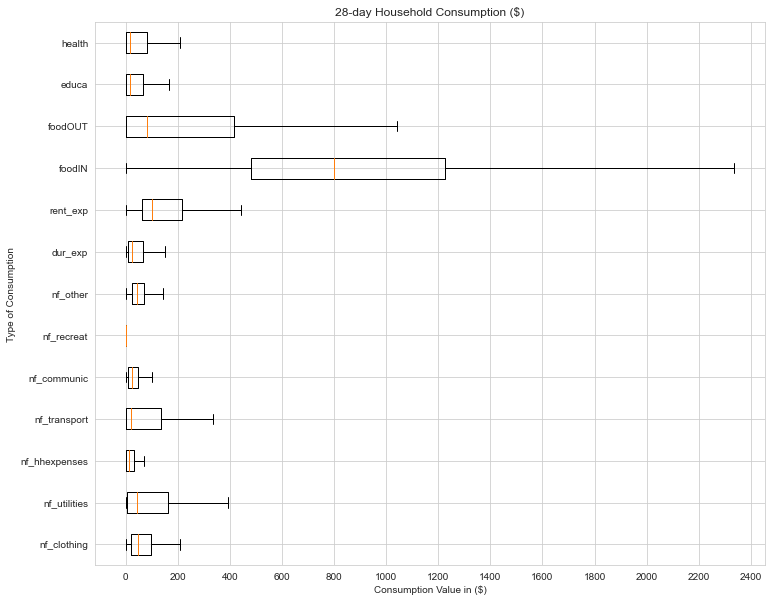

<Figure size 432x288 with 0 Axes>

In [24]:
# Create a figure and axes with custom background color
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light grey background color

sns.barplot(x=electricity_source_counts.index,
            y=electricity_source_counts.values,
            palette = custom_palette)

# Customize chart title and labels
plt.title('Distribution of Electricity Sources', fontsize=15, color='navy')
plt.xticks(rotation=45, fontsize=11, color='dimgray')
plt.yticks(fontsize=11, color='dimgray')
plt.xlabel('Electricity Source', fontsize=12, color='black')
plt.ylabel('%age of Households', fontsize=12, color='black')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.6, color='gray')

# Customize tick parameters
ax.tick_params(axis='x', which='both', bottom=False)

# Annotate the bars with values (optional)
for i, v in enumerate(electricity_source_counts.values):
    plt.text(i, v, f'{v:.2f}%', fontsize=8, ha='center', va='bottom', color='black')

plt.show()

# Adjust the figure size and margins
plt.gcf().subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.9)
plt.savefig('Distribution of Electricity Sources.png', dpi = 300, format = 'png')

In [24]:
sns.set()
plt.figure(figsize=(10, 5))
sns.countplot(data=i_hh_energy[i_hh_energy['electricity_source'] == 'Solar Panels'], x='cooking_fuel')
plt.title('Cooking Fuel for Solar Panel Households')
plt.xlabel('Cooking Fuel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
crosstab = pd.crosstab(i_hh_energy['cooking_fuel'], i_hh_energy['lighting_fuel'])

# Create a heatmap to visualize relationships
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt = 'd', cmap='YlGnBu')
plt.title('Heatmap of Cooking Fuel vs. Lighting Fuel')
plt.xlabel('Lighting Fuel')
plt.ylabel('Cooking Fuel')
plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the custom style and context for Seaborn
sns.set(style='whitegrid', palette='Set2', font_scale=1.2)

######

# Create a crosstab
crosstab = pd.crosstab(i_hh_energy['cooking_fuel'], i_hh_energy['lighting_fuel'])

# Create a heatmap to visualize relationships
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')

# Customize chart title and labels
plt.title('Heatmap of Cooking Fuel vs. Lighting Fuel', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Lighting Fuel', fontsize=14, fontweight='bold', color='dimgray')
plt.ylabel('Cooking Fuel', fontsize=14, fontweight='bold', color='dimgray')

# Show the chart
plt.show()

# Adjust the figure size and margins
plt.gcf().subplots_adjust(left=0.1, right=0.9, bottom=0.3, top=0.9)
plt.savefig('cooking fuels vs lighting fuels.png', dpi = 300, format = 'png')


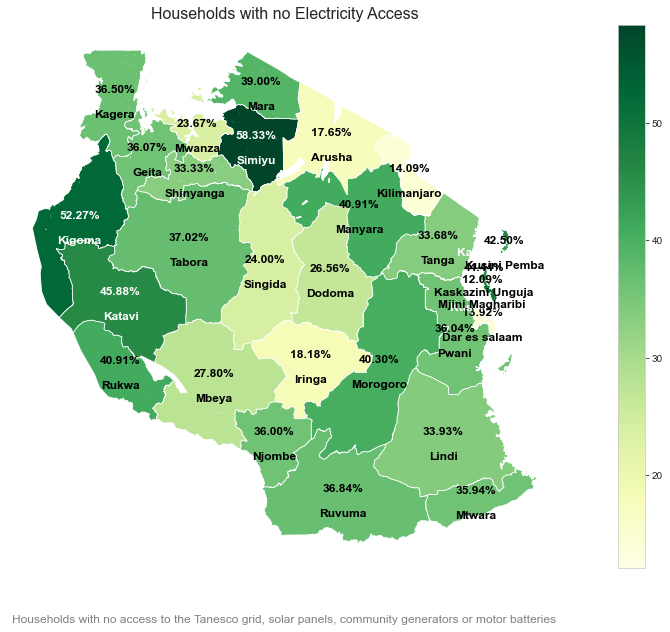

<Figure size 432x288 with 0 Axes>

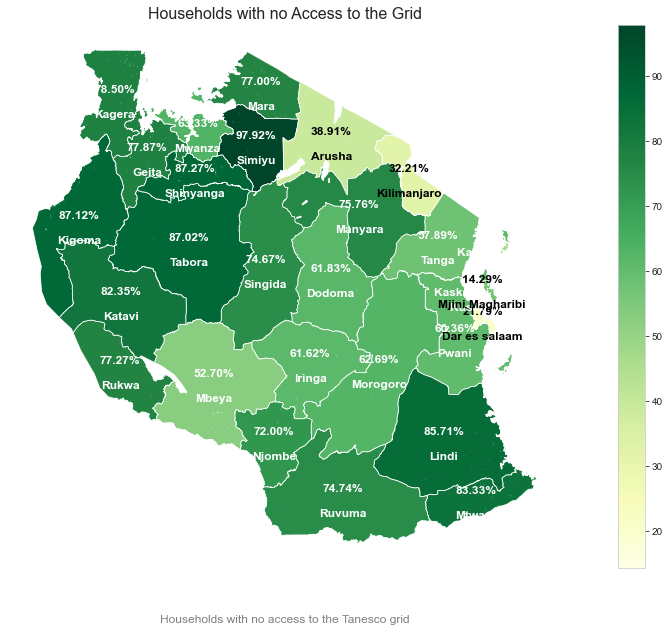

<Figure size 432x288 with 0 Axes>

In [29]:
columns_of_interest = ['cooking_fuel', 'cooking_stove', 'lighting_fuel']
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(15, 5))

for i, col in enumerate(columns_of_interest):
    sns.countplot(data=i_hh_energy[i_hh_energy['electricity_source'] == 'Solar Panels'], x=col, ax=axes[i])
    axes[i].set_title(f'{col} for Solar Panel Households')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

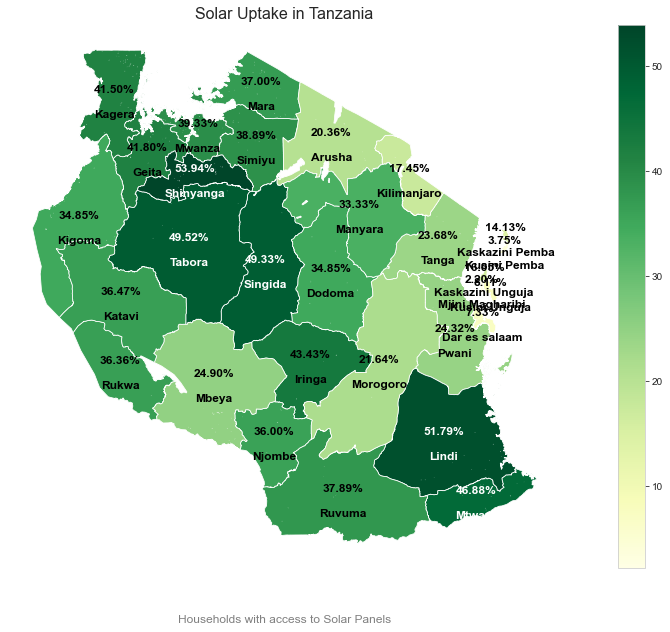

<Figure size 432x288 with 0 Axes>

In [30]:
i_hh_energy['lighting_fuel'].value_counts()

In [30]:
filtered_df = i_hh_energy[~((i_hh_energy['lighting_fuel'] == 'Electricity') | (i_hh_energy['lighting_fuel'] == 'Solar'))]
filtered_df

In [ ]:
combination_counts = i_hh_energy.groupby(['electricity_source', 'lighting_fuel']).size().reset_index(name='count')
# print(combination_counts)

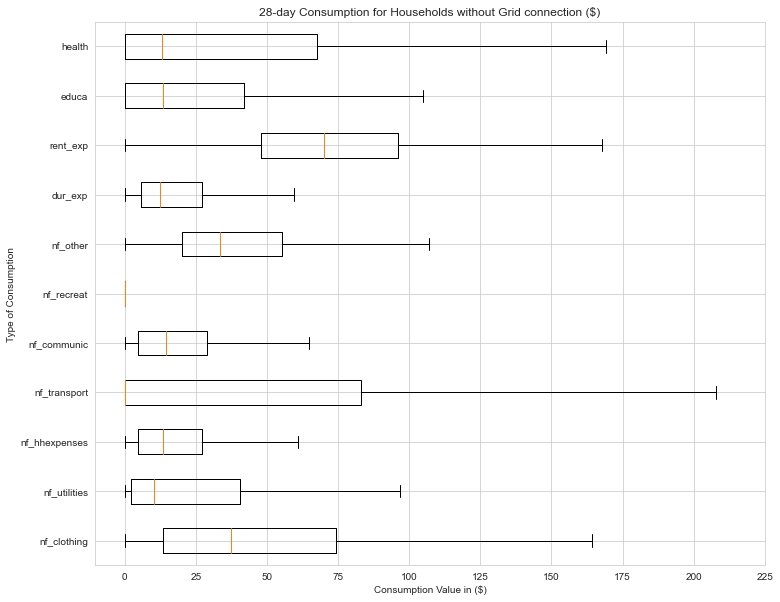

<Figure size 432x288 with 0 Axes>

In [31]:
crosstab = pd.crosstab(i_hh_energy['electricity_source'],
                       i_hh_energy['lighting_fuel'])

# Create a heatmap to visualize relationships
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt = 'd', cmap='YlGnBu')
plt.title('Heatmap of Electricity Source vs. Lighting Fuel')
plt.xlabel('Lighting Fuel')
plt.ylabel('Electricity Source')
plt.show()

In [32]:
# Create the cross-tabulation table
crosstab = pd.crosstab(i_hh_energy['electricity_source'], i_hh_energy['lighting_fuel'])

# Calculate the total count of all observations
total_count = crosstab.values.sum()

# Calculate the percentages by dividing each cell by the total count
percentage_crosstab = (crosstab / total_count) * 100

# Create a heatmap to visualize relationships using percentages
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_crosstab, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Mode of lighting vs electricity source (%age of households)')
plt.xlabel('Mode of lighting')
plt.ylabel('Electricity Source')
plt.show()

,nf_clothing,nf_utilities,nf_hhexpenses,nf_transport,nf_communic,nf_recreat,nf_other,dur_exp,rent_exp,foodIN,foodOUT,educa,health
7,242.0,268.16,61.6,856.00,96.0,0.0,218.00,137.335380,127.835213,4160.0000,977.60,24.0,0.00
9,56.8,174.88,0.0,0.00,24.0,0.0,86.40,35.413411,311.221500,1003.6000,291.20,476.0,0.00
13,67.6,0.00,4.0,2.08,48.0,0.0,20.16,9.011622,95.678606,0.0000,470.08,0.0,0.00
17,61.6,140.32,9.6,183.04,28.8,0.0,45.60,14.528269,96.000000,744.6400,640.64,0.0,43.16
23,37.6,48.00,2.4,37.44,14.4,0.0,38.40,2.414926,88.902813,493.2238,330.72,0.0,88.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,94.0,59.68,28.8,0.00,48.0,0.0,148.80,17.196497,117.982363,1595.3600,291.20,12.0,26.00
4695,57.2,40.48,0.0,83.20,28.8,2.8,72.00,29.675316,67.652462,1273.3067,62.40,12.0,62.40
4698,6.4,93.28,0.0,20.80,38.4,0.0,33.60,3.808139,144.168138,688.4800,0.00,0.0,5.20
4703,202.0,40.48,0.0,145.60,0.0,0.0,105.60,15.695562,147.224038,1231.1124,0.00,0.0,0.00


In [33]:
consumption_data = data_dict['consumption_real_y5']
consumption_data = consumption_data[['y5_hhid','urban','region','district','hhsize','nf_clothing', 'nf_utilities', 'nf_hhexpenses', 'nf_transport', 'nf_communic', 'nf_recreat', 'nf_other', 'dur_exp', 'rent_exp', 'foodIN', 'foodOUT', 'educa', 'health']]

In [34]:
consumption_data.iloc[:, 5:] = consumption_data.iloc[:, 5:] * fx
# consumption_data

expenditure_item,Cell phone voucher,"Electricity, including electricity vouchers",Gas (for lighting/cooking),Kerosene,Light bulbs,Petrol or diesel,charcoal,non_energy,total_expenditure
y5_hhid,,,,,,,,,
1000-001-01,0.084746,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.915254,1.0
1000-001-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
1000-001-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
1000-001-06,0.104167,0.034722,0.000000,0.000000,0.000000,0.0,0.000000,0.861111,1.0
1001-001-01,0.597015,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.402985,1.0
...,...,...,...,...,...,...,...,...,...
9807-001-99,0.163399,0.027233,0.119826,0.000000,0.065359,0.0,0.000000,0.624183,1.0
9808-001-99,0.082093,0.025654,0.000000,0.000000,0.015393,0.0,0.153925,0.722935,1.0
9809-001-99,0.054250,0.000000,0.000000,0.090416,0.000000,0.0,0.000000,0.855335,1.0


In [34]:
# Let's visualise the consumption of the households
plt.figure(figsize=(12, 10))
plt.boxplot(consumption_data.iloc[:, 5:].values,
            labels = consumption_data.iloc[:, 5:].columns,
            vert=False,
            showfliers = False)
plt.xticks(range(0, 2500, 200))
plt.title('28-day Household Consumption ($)')
plt.xlabel('Consumption Value in ($)')
plt.ylabel('Type of Consumption')
plt.show()

plt.savefig('hh_consumption.png', dpi = 300, format = 'png')

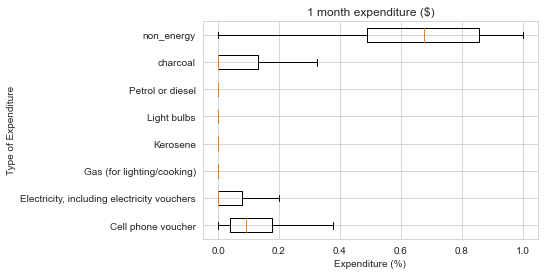

In [35]:
consumption_data_w_energy = consumption_data.merge(i_hh_energy, how = 'left', on = 'y5_hhid')

In [36]:
consumption_data_w_energy['region'].value_counts()

In [37]:
# compute the total number of households
avg_hh_size = consumption_data_w_energy['hhsize'].mean()
total_hhs = total_population / avg_hh_size
total_hhs

In [38]:
consumption_data_w_energy

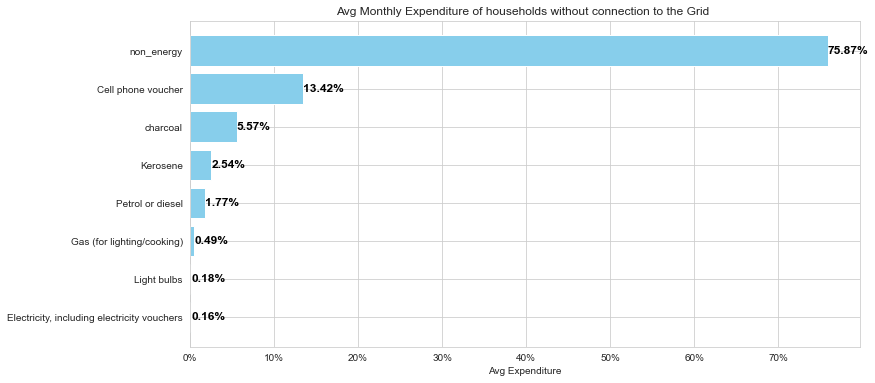

NameError: name 'energy_specific_exp' is not defined

In [ ]:
gdf['Region_Cod'] = gdf['Region_Cod'].astype(int)
consumption_data_w_energy = consumption_data_w_energy.merge(gdf, how = 'left', left_on = 'region', right_on = 'Region_Cod')
# Create a deo
geo_df = gpd.GeoDataFrame(consumption_data_w_energy, geometry='geometry')

In [ ]:
consumption_data_w_energy['electricity_source'].value_counts()

In [ ]:
# Group by Region_Name and calculate the percentage of households with "no-electricity"
percentage_data = consumption_data_w_energy.groupby('Region_Nam')['electricity_source'].apply(lambda x: (x == 'no-electricity').mean() * 100)
percentage_data

In [ ]:
gdf

In [ ]:
# Merge the percentage data with a GeoDataFrame containing region geometries
merged_gdf = gdf.merge(percentage_data, left_on='Region_Nam', right_index=True)

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20,10))
merged_gdf.plot(column='electricity_source', cmap='YlGn', linewidth=0.8, ax=ax, legend=True)

main_title = 'Households with no Electricity Access'
subtitle = 'Households with no access to the Tanesco grid, solar panels, community generators or motor batteries'
ax.set_title(main_title, fontsize=16)
plt.text(0.5, -0.1, subtitle, transform=ax.transAxes, ha='center', fontsize=12, color='gray')
plt.axis('off')  # Turn off axis

# Annotate each region with the name and value
for idx, row in merged_gdf.iterrows():
    region_name = row['Region_Nam']
    percentage = row['electricity_source']
    centroid_x, centroid_y = row['geometry'].centroid.x, row['geometry'].centroid.y

    # Determine the background color and set text color accordingly
    background_color = 'white' if percentage > 45 else 'black'

    # Annotate the region name with the determined text color
    plt.annotate(region_name, xy=(centroid_x, centroid_y), xytext=(0, -20),
                 textcoords='offset points', fontsize=12, color=background_color, ha='center', weight = 'bold')

    # Annotate the percentage below the region name
    plt.annotate(f"{percentage:.2f}%", xy=(centroid_x, centroid_y), xytext=(0, 5),
                 textcoords='offset points', fontsize=12, color = background_color, ha='center', weight = 'bold')

plt.show()
plt.savefig('tz_no_electricity_access.jpeg', dpi = 300, bbox_inches = 'tight')

#### Earnings DATA

In [ ]:
data_dict['hh_sec_e1']#['hh_e35b'].value_counts()

In [ ]:
time_unit_wages = { 1:'Hour',
                    2:'Day',
                    3:'Week',
                    4:'Fortnight',
                    5:'Month',
                    6:'Quarter',
                    7:'Half Year',
                    8:'Year'}

In [ ]:
# individual-level data on earnings/labour
hh_income = data_dict['hh_sec_e1'][['y5_hhid','indidy5','hh_e35a','hh_e35b','hh_e36','hh_e37a','hh_e37b','hh_e38','hh_e39','hh_e41','hh_e51a','hh_e51b','hh_e52','hh_e53a','hh_e53b','hh_e54' ]]

In [ ]:
hh_income = hh_income.rename(columns = {    'hh_e35a':'pri_pay_amt',
                                            'hh_e35b':'pri_pay_period',
                                            'hh_e36':'pri_pay_nc',
                                            'hh_e37a':'pri_pay_nc_amt',
                                            'hh_e37b':'pri_pay_nc_period',
                                            'hh_e38':'months_per_yr',
                                            'hh_e39':'wks_per_month',
                                            'hh_e40':'hrs_per_wk',
                                            'hh_e41':'hrs_l7d',
                                            'hh_e51a':'sec_pay_amt',
                                            'hh_e51b':'sec_pay_period',
                                            'hh_e52':'sec_pay_nc',
                                            'hh_e53a':'sec_pay_nc_amt',
                                            'hh_e53b':'sec_pay_nc_period',
                                            'hh_e54':'hrs_l7d'})

In [ ]:
hh_income = hh_income.fillna(1)

In [ ]:
hh_income['pri_pay_period'].value_counts()

In [ ]:
# Create Choropleth Map
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# gdf.plot(column='Value', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
# ax.set_title('Choropleth Map')
# plt.axis('off')  # Turn off axis
# plt.show()

In [ ]:
# Dictionary mapping pri_pay_period to multiplier_pri_a
# Assumption: daily labourers work for 25 days
# multiplier_mapping = {
#     1: lambda row: row['wks_per_month'] * row['hrs_l7d'] * row['wks'],
#     2: 28,
#     3: lambda row: row['wks_per_month'],
#     4: 2,
#     5: 1,
#     6: 1 / 3,
#     7: 1 / 6,
#     8: 1 / 12
# }
#
# # Function to calculate multiplier_pri_a based on pri_pay_period
# def calculate_multiplier(row):
#     return multiplier_mapping.get(row['pri_pay_period'], 0)


#def calculate_multiplier(row, pay_period_column):
#    return multiplier_mapping.get(row[pay_period_column], 0)

In [ ]:
# hh_income['multi_col_a'] = hh_income['wks_per_month'] * hh_income['hrs_l7d']


# cash income
# hh_income['multiplier_pri_a'] = hh_income.apply(calculate_multiplier, axis=1)
# hh_income['multiplier_pri_a'] = hh_income.apply(calculate_multiplier, axis=1)
# hh_income ['monthly_cash_pri'] = hh_income['multiplier_pri_a'] * hh_income['pri_pay_amt']


#hh_income[['pri_pay_amt']] * hh_income[['multiplier_pri_a']]

#### Energy Expenditure

In [ ]:
energy_specific_exp = data_dict['hh_sec_k']

In [ ]:
energy_specific_exp

In [ ]:
expenditure_items = {   201:'Kerosene',
                        202:'Electricity, including electricity vouchers',
                        203:'Gas (for lighting/cooking)',
                        205:'Petrol or diesel',
                        206:'Cell phone voucher',
                        207:'charcoal',
                        216:'Light bulbs',
                        414:'Lanterns',
                        419:'Electric/gas stove',
                        420:'Other stove',
                        421:'Water-heater'}

Pick up from Section N of the questionnaire after adding expenditure_items (items and amounts) from hh_sec_k and and income data (hh_sec_e1) to the dataframe cons_data

In [ ]:
energy_specific_exp['energy_item'] = energy_specific_exp['itemcode'].map(expenditure_items).fillna('not_energy')

In [ ]:
energy_specific_exp = energy_specific_exp[energy_specific_exp['hh_k01'] == 1.0].fillna(0)

In [ ]:
energy_specific_exp

In [ ]:
pivot_table = pd.pivot_table(energy_specific_exp, values='hh_k02', index='y5_hhid', columns='energy_item', aggfunc='sum', fill_value=0)

# Add a column for total household expenditure
pivot_table['total_expenditure'] = pivot_table.sum(axis=1)

# Print the pivot table
pivot_table